In [5]:
import matplotlib.pyplot as plt
import numpy as np
from KDEpy import NaiveKDE
import scipy.integrate as integrate
from function_library_3 import trim, haversine
from tqdm import tqdm
import pickle
import random

#================================================================================
# SETUP

#change default font size for graphs
plt.rcParams.update({'font.size':20})

# create the needed directories and clear old output
import os,glob
try:
    os.mkdir('3_Pressure_Distributions')
except:
    for filename in glob.glob('3_Pressure_Distributions/*'):
        os.remove(filename)
try:
    os.mkdir('3_Temperature_Distributions')
except:
    for filename in glob.glob('3_Temperature_Distributions/*'):
        os.remove(filename)
        
try:
    os.mkdir('3_Map_Distributions')
except:
    pass


# suppress warnings
import warnings
warnings.filterwarnings('ignore')

#================================================================================
# GLOBAL PARAMETERS

collection_depth = 1e-3 #km
minimum_mixing_depth = 10e-3 #km

likelihood_threshold = 0.5 #.6826 #fraction of material needed to credit to source

R_planet = 1750

def get_mixing_depth(): # returns the depth of mixing below the new ejecta (inclusive)
    return minimum_mixing_depth
# this can be adapted so as to make the mixing depth a function of other variables... 
# such as the length of time between impacts or the distance from the most recent impact

In [6]:
#================================================================================
# CREATE DATAFRAME

file_list = [] # generate a list of the included basins
for filename in os.listdir('1_Basin_Data'):
    if filename.endswith(".dat"):
         file_list.append(filename[:-4])
            
data_framework = {}

for each in tqdm(file_list):
    # extract the data from the KDE data
    fileKDE  = open('2_KDE_Data/{}.dat'.format(each),'rb')
    full_data = pickle.load(fileKDE)
    fileKDE.close()
    data_framework[each] = full_data

100%|██████████████████████████████████████████| 30/30 [00:00<00:00, 528.34it/s]


In [14]:
#================================================================================
# RETRIEVE BASIN ORDER DATA

# Open the user input file with the information from each basin
input_file = open('Basins.txt','r')
basins = []
basin_order = []
impact_order = []
line = 1,' '
while line[0:3] != 'END':
    line = input_file.readline()
    if line[0:1] == 'B':
        basins.append(trim(line.split(':'))) 
        basin_order.append(basins[-1][0])
        impact_order.append(basins[-1][4])
    
impact_order, basin_order, basins = zip(*sorted(zip(impact_order, basin_order, basins)))

print(basin_order)

color_code = {'Formation':'black', 'empty':'white'}
for each in basins:
    color_code[each[0]] = each[5]

#================================================================================
# DEFINE CROSS-SECTION FUNCTION

def cross_section(loc, param, cover=False):  # take a slice of the pressure and temperature 2D KDEs  
    # basin name    2D KDE values    Ejecta depth values  
    basin,  XS, PS, TS, ZP, ZT, height_val = param
    #             loc  pres   Temp         height 
    #---------------------------------------
    # data is interpolated linearly between the two surounding columns closest the to landing location
    
    #---------------------------------------
    # interpolate ejecta depth curve 
    
    # find the cloest two x values
    lower_ratio = upper_ratio = .5
    if loc < XS[0]:
        lower_index = upper_index = 0
    elif XS[-1] < loc:
        lower_index = upper_index = -1
    else:
        for i in range(len(XS)):
            if XS[i] <= loc <= XS[i+1]: # locate the two points that need to be interpolated
                lower_index = i
                upper_index = i+1
                lower_ratio = (loc - XS[i])/(XS[i+1]-XS[i])
                upper_ratio = (XS[i+1] - loc)/(XS[i+1]-XS[i])
                break 
    
    #calculate the height        
    height_accum = lower_ratio*height_val[upper_index] + upper_ratio*height_val[lower_index]
    
    if cover:
        # returns a ejecta depth value
        return height_accum
        
    #---------------------------------------
    
    Pval = lower_ratio*ZP[:,upper_index] + upper_ratio*ZP[:,lower_index]
    Tval = lower_ratio*ZT[:,upper_index] + upper_ratio*ZT[:,lower_index]
    
    #---------------------------------------
    # returns a ejecta depth value, pressure curve, temperature curve
    return height_accum, PS, Pval, TS, Tval

#================================================================================
# DEFINE MAIN FUNCTION

def distribution(title_loc, N_sample, E_sample, cover=False): # create pressure distributions at the sample site

    if not cover:
        print('============================================================================')
        print(title_loc)
        print('============================================================================')
    
    #---------------------------------------
    # begin combining the pressure/temperature distributions
    
    # initialize lists 
    names = ['Formation'] ; colors = ['black'] ; radii = [0] ; distances = [0] # names of each basin, diameter of basin, and distance from sample site to center of basin
    heights = np.array([R_planet])
    mixing_depths = np.array([None])
    
    if not cover: Px, Pv, Tx, Tv = [],[],[],[]
    # respective ejecta depths and pressure/temperature distributions from each basin
    
    # cycle through each basin for their contribution
    for each in basins:
        # extract the data from the KDE data
        full_data = data_framework[each[0]]
        names.append(each[0]) # names of each basin
        colors.append(each[5]) # colors of each basin
        N_basin = each[1] # latitude of basin
        E_basin = each[2] # longitude of basin
        planet_radius = R_planet # radius of planet
        distances.append(haversine(N_basin,E_basin,N_sample,E_sample,planet_radius)) # distance from sample site to center of basin 
        radii.append(each[3]/2) # radius of each basin
        
        if not cover : H_0,P_0,Pv_0,T_0,Tv_0 = cross_section(distances[-1],full_data) # respective ejecta depthes and pressure/temperature distributions from each basin
        if radii[-1] > distances[-1]: # determine if the sample site is from within the basin
            H_0 = radii[-1] / 10.
        elif cover:
            H_0 = cross_section(distances[-1],full_data,cover=cover)

        # add to each list
        heights = np.append(heights,H_0)
        mixing_depths = np.append(mixing_depths, get_mixing_depth()  )
        
        if not cover: 
            Px.append(P_0) ; Pv.append(Pv_0) ; Tx.append(T_0) ; Tv.append(Tv_0)
        
    total_before_mixing = np.sum(heights) - R_planet
    
    mixing_depths = np.append(mixing_depths, collection_depth)

    layers = mixing_model(heights,mixing_depths)
    
    heights = layers[-1]
    
    if not cover:
        # add in the formation 
        Px.insert(0,P_0) ; Pv.insert(0,np.zeros(len(Pv_0)))
        Tx.insert(0,T_0) ; Tv.insert(0,np.zeros(len(Tv_0)))
        
        #---------------------------------------
        # synchronize the patterns
        random.seed(1)
        lines = ["--","-.",":"]
        pattern = {}
        
        for each in names:
            line_type = lines[random.randint(0,2)]
            pattern[each] = line_type
        
        # all the px and Tx are identical... so we can collapse that array:
        Px = Px[0]
        Tx = Tx[0]
    
    # sort the ejecta depths so that they can be ranked
    sorted_heights = []
    for each in heights:
        sorted_heights.append(each)
    sorted_heights.sort() ; sorted_heights.reverse()
    
    # rank the ejecta depths
    i = 0 ; rankings = {}
    for each in sorted_heights:
        if each in rankings.keys():
            rankings[each] = i
        else:
            i += 1
            rankings[each] = i    
            
    if cover:
        for i in range(len(names)):
            if heights[i] < 1e-6 : # skip basin if it has no contributions
                continue
        
            rank = rankings[heights[i]]
            if rank == 1 and sorted_heights[0]/np.sum(sorted_heights) > likelihood_threshold:
                return(names[i])     
        return 'empty'

    print('{:0.05f} km of ejecta from all basins before mixing'.format(total_before_mixing))
    print('{:0.05f} km of ejecta from all basins after mixing'.format(np.sum(layers)-R_planet))
    print('{:0.05f} km of ejecta in collection layer'.format(np.sum(heights)))
    print('----------------------------------------------------------------------------')
    
    print('Deposited Ejecta Proportion at {}'.format(title_loc))
    for i in range(len(names)):
        if heights[i] < 1e-6 : # skip basin if it has no contributions
            continue
            
        sample_to_center = '| {:04d} km away '.format(int(distances[i]))
        
        sample_to_edge = '| {:04d} km from edge '.format(int(distances[i] - radii[i]))
        if radii[i] > distances[i]: # determine if the sample site is from within the basin
            sample_to_edge = '| {:04d} km within edge '.format(int(radii[i] - distances[i]))
        
        # print the details from each basin
        rank = rankings[heights[i]]
        extra_space = ''
        if rank < 10 :
            extra_space = ' '
            
        percentage = 100*heights[i]/np.sum(heights)
        percentage = "{:.02f}".format(percentage).zfill(5)
        
        print('{}% (#{}){} | from {:15s}  '.format( percentage, rank, extra_space, names[i] ) + sample_to_center+sample_to_edge )

        
    print('============================================================================')
    
    # initialize lists
    P_AbunEach, P_AbunTotal = [], 0
    T_AbunEach, T_AbunTotal = [], 0

    for i in range(len(names)): # add up contributions from each basin
        if heights[i] < 1e-6 or names[i] == 'Formation': # skip basin if it has no contributions
            P_AbunEach.append(None) # add in dummy placeholders for empty non-contributing basins
            T_AbunEach.append(None) # add in dummy placeholders for empty non-contributing basins
            continue
            
        P_norm = integrate.trapz(Pv[i], x=Px)
        T_norm = integrate.trapz(Tv[i], x=Tx)
        P_AbunEach.append(heights[i]/P_norm*np.array(Pv[i])) # normalize by the ejecta depth / area under the pressure curve
        T_AbunEach.append(heights[i]/T_norm*np.array(Tv[i])) # normalize by the ejecta depth / area under the temperature curve 
        P_AbunTotal += P_AbunEach[-1] # combined pressure distribution curve
        T_AbunTotal += T_AbunEach[-1] # combined temperature distribution curve
        
    AreaP = integrate.trapz(P_AbunTotal,x=Px) # area under the total pressure curve
    AreaT = integrate.trapz(T_AbunTotal,x=Tx) # area under the total temperature curve
    
    
    #---------------------------------------
    # plot the pressure distributions
    
    fig = plt.figure(figsize=(16,8),facecolor='white')
    plt.suptitle('Pressure Distribution at {}'.format(title_loc), fontsize=32)
    ax = fig.add_subplot(111) 
    
    #ax.set_title('Pressure PDF', fontsize=24)
    ax.set_xlabel('Pressure [GPa]', fontsize=24)
    ax.set_ylabel('Probability Density', fontsize=24)
    
    ax.plot(Px, P_AbunTotal/AreaP, c='black', label='(Combined)', alpha=.5) # plot combined distribution
        
    for i in range(len(names)): # plot each basin's pressure distribution
        if heights[i] < 1e-6 or names[i] == 'Formation': # skip basin if it has no contributions
            continue
        lsc = pattern[names[i]]
        ax.plot(Px, P_AbunEach[i]/AreaP, ls=lsc, c=color_code[names[i]], label=names[i])
                
    ax.grid(True, ls='--', zorder=-15); ax.legend(fontsize=24,title='In Order of Proximity');
    
    fig.savefig('3_Pressure_Distributions/Pressure Distribution at {}.png'.format(title_loc))
    plt.close(fig)

    #---------------------------------------
    # plot the temperature distributions
    
    fig = plt.figure(figsize=(16,8),facecolor='white')
    plt.suptitle('Temperature Distribution at {}'.format(title_loc), fontsize=32)
    ax = fig.add_subplot(111) 
    
    #ax.set_title('Temperature PDF', fontsize=24)
    ax.set_xlabel('Temperature [K]', fontsize=24)
    ax.set_ylabel('Probability Density', fontsize=24)
    
    ax.plot(Tx, T_AbunTotal/AreaT, c='black', label='(Combined)', alpha=.5) # plot combined distribution
    
    for i in range(len(names)): # plot each basin's temperature distribution
        if heights[i] < 1e-6 or names[i] == 'Formation': # skip basin if it has no contributions
            continue
        lsc = pattern[names[i]]
        ax.plot(Tx, T_AbunEach[i]/AreaT, ls=lsc, c=color_code[names[i]], label=names[i])
    
    ax.grid(True, ls='--', zorder=-15); ax.legend(fontsize=24,title='In Order of Proximity');
        
    fig.savefig('3_Temperature_Distributions/Temperature Distribution at {}.png'.format(title_loc))
    plt.close(fig)

#================================================================================
# DEFINE THE MIXING MODEL FUNCTION

def mixing_model(heights,mixing_depths,test=False):

    # start the mixing model
    layers = np.array( [[0. for col in range(len(mixing_depths)-1)] for row in range(len(mixing_depths))] )
    
    # initialize the layers stacked on top eachother mithout any mixing
    for event in range(len(heights)):
        layers[event][event] = heights[event]
        
    if test: print('\nfirst row is already mixed by default')
    if test: print(layers)
    
    # mix each layer one by one
    for event in range(1,len(mixing_depths)):
        mixed_in_depth = mixing_depths[event]
        if test: print('\nnow mixing row {} by ({}):'.format(event+1,mixed_in_depth))
        g = 1 # number of generations that we look back in time
        while True:
            prev_layer_thickness = np.sum(layers[event-g])
            if mixed_in_depth <= prev_layer_thickness:
                # if the depth of mixing is less than previous layer, mix in fraction of the layer
                mixed_in_layer = layers[event-g] * mixed_in_depth/prev_layer_thickness
                layers[event  ] += mixed_in_layer #place in new layer
                layers[event-g] -= mixed_in_layer #remove
                if test: print(layers)
                if test: print('reached mixing depth, row {} is mixed:\n'.format(event+1))
                break
            elif mixed_in_depth > prev_layer_thickness:
                # if the depth of mixing is greater than the previous layer, than just mix in the entire layer
                mixed_in_layer = layers[event-g]
                layers[event  ] += mixed_in_layer #place in new layer
                layers[event-g] -= mixed_in_layer #remove
                mixed_in_depth -= prev_layer_thickness
                g += 1
                if test: print(layers)
                if test: print('must mix deeper:')
            else:
                print('something went wrong') 
    return layers
        
        

('SPoleAitkens', 'Nubium', 'Birkoff', 'Ingenii', 'AmundsenG', 'CrugerS', 'FitzgeraldJ', 'Smythii', 'SchillerZ', 'CoulombS', 'DirichletJ', 'Poincare', 'Serenitatis', 'Lorentz', 'Nectaris', 'Apollo', 'FreundlichS', 'Grimaldi', 'MendelR', 'Mendeleev', 'Planck', 'Korolev', 'Hertzsprung', 'Humorum', 'Moscoviense', 'Humboldtainum', 'Crisium', 'Imbrium', 'Schrodinger', 'Orientale')


In [15]:
# Open the user input file with the information from each sample
input_file = open('Sample_Sites.txt','r')
samples = []
line = 1,' '
while line[0:3] != 'END':
    line = input_file.readline()
    if line[0:1] == 'S':
        samples.append(trim(line.split(':'))) 
        
for each in samples:
    distribution(each[0],each[1],each[2])

Apollo 11
0.75735 km of ejecta from all basins before mixing
0.75735 km of ejecta from all basins after mixing
0.00100 km of ejecta in collection layer
----------------------------------------------------------------------------
Deposited Ejecta Proportion at Apollo 11
00.50% (#3)  | from Nectaris         | 0591 km away | 0146 km from edge 
00.15% (#4)  | from Humorum          | 1995 km away | 1585 km from edge 
07.70% (#2)  | from Crisium          | 1167 km away | 0627 km from edge 
91.50% (#1)  | from Imbrium          | 1515 km away | 0855 km from edge 
Apollo 12
0.49789 km of ejecta from all basins before mixing
0.49789 km of ejecta from all basins after mixing
0.00100 km of ejecta in collection layer
----------------------------------------------------------------------------
Deposited Ejecta Proportion at Apollo 12
01.61% (#3)  | from Humorum          | 0788 km away | 0378 km from edge 
00.99% (#4)  | from Crisium          | 2552 km away | 2012 km from edge 
65.88% (#1)  | from Im

In [16]:
distribution('SPA',-75,50)

SPA
1.16694 km of ejecta from all basins before mixing
1.16694 km of ejecta from all basins after mixing
0.00100 km of ejecta in collection layer
----------------------------------------------------------------------------
Deposited Ejecta Proportion at SPA
06.09% (#6)  | from SPoleAitkens     | 1509 km away | 0259 km from edge 
00.68% (#14) | from Nubium           | 1950 km away | 1605 km from edge 
03.42% (#8)  | from AmundsenG        | 0458 km away | 0288 km from edge 
02.42% (#9)  | from Smythii          | 2324 km away | 1884 km from edge 
00.51% (#15) | from SchillerZ        | 1160 km away | 0980 km from edge 
00.22% (#17) | from Poincare         | 1257 km away | 1102 km from edge 
01.82% (#10) | from Serenitatis      | 3178 km away | 2718 km from edge 
09.96% (#4)  | from Nectaris         | 1849 km away | 1404 km from edge 
01.00% (#12) | from Apollo           | 2081 km away | 1836 km from edge 
00.17% (#18) | from FreundlichS      | 3582 km away | 3292 km from edge 
00.27% (#16)

In [10]:
#longitude = np.linspace(-60,75,60+75+1)
#latitude = np.linspace(-15,60,15+60+1)

longitude = np.linspace(-180,180,180+180+1)
latitude = np.linspace(-90,90,90+90+1)
origin = []
for N in tqdm(latitude):
    for E in longitude:
        origin.append(distribution(None,N,E,cover=True))
        
colors = []
for each in origin:
    colors.append(color_code[each])   
    
Lat = [] ; Lon = []
x_values, y_values,z_values = [],[],[]
R = 1 ; i=0
for N in latitude:
    for E in longitude:
        Lat.append(N) ; Lon.append(E)
        x_values.append(R*np.sin(np.radians(-N+90))*np.cos(np.radians(E)))
        y_values.append(R*np.sin(np.radians(-N+90))*np.sin(np.radians(E)))
        z_values.append(R*np.cos(np.radians(-N+90)))
        i += 1
        if i == len(origin):
            break
    if i == len(origin):
            break

100%|█████████████████████████████████████████| 181/181 [01:58<00:00,  1.53it/s]


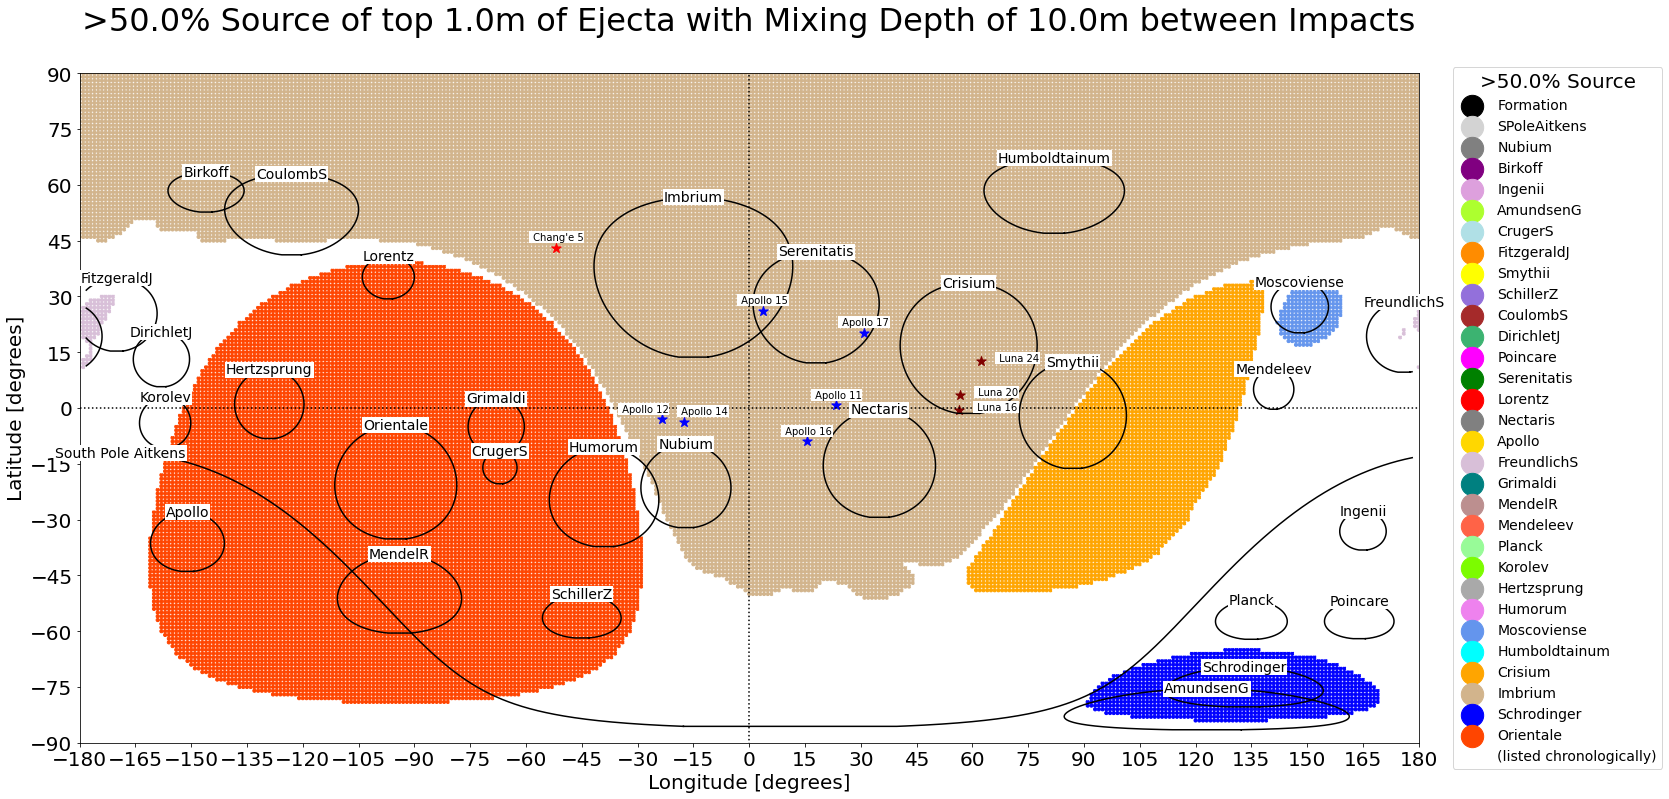

In [11]:
from function_library_3 import solve,process,transform # helps with mercator projection

A_sites = {11:[0.67409,23.47298],12:[-3.01381,-23.41930],14:[-3.64544,-17.47139],15:[26.13224,3.63400],16:[-8.97341,15.49859],17:[20.18809,30.77475]}
L_sites = {16:[-.5137,56.3638],20:[3.5333,56.55],24:[12.7145,62.2129]}
C_sites = {5:[43.1,-51.8]}
    
fig = plt.figure(figsize=(24,24),facecolor='white') ; ax = fig.add_subplot(111,aspect='equal',xmargin=10)

#img = plt.imread("Mercator.png")
#ax.imshow(img, extent=[-180, 180, -90, 90], alpha=1)

plt.scatter(Lon,Lat,c=colors,s=10,alpha=1)

ax.plot([0,0], [-180,180], ls=':', color='black') ; ax.plot([-180,180], [0,0], ls=':', color='black');

for each in A_sites.keys():
    fix = 0
    if each == 14: fix = 5
    if each == 12: fix = -5
    ax.text(A_sites[each][1]+fix,A_sites[each][0]+2,' Apollo '+str(each),fontsize=10, ha='center', bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1})
    ax.scatter(A_sites[each][1],A_sites[each][0],marker='*',s=100,c='blue')
    
for each in L_sites.keys():
    fix = 10
    ax.text(L_sites[each][1]+fix,L_sites[each][0],' Luna '+str(each),fontsize=10, ha='center', bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1})
    ax.scatter(L_sites[each][1],L_sites[each][0],marker='*',s=100,c='maroon')
    
for each in C_sites.keys():
    ax.text(C_sites[each][1],C_sites[each][0]+2," Chang'e "+str(each),fontsize=10, ha='center', bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1})
    ax.scatter(C_sites[each][1],C_sites[each][0],marker='*',s=100,c='red')
    
for each in basins:
    name = each[0]
    if name == 'SPoleAitkens': name = 'South Pole Aitkens'
    R_basin = each[3]/2 ; lam1 = np.radians(each[1]) ; phi1 = np.radians(each[2])
        
    lam_max = lam1 + R_basin/R_planet
    if lam_max > np.pi/2: lam_max = np.pi - lam_max
    lam_min = lam1 - R_basin/R_planet
    if lam_min < -np.pi/2: lam_min = -np.pi - lam_min
        
    latitudes = transform(np.linspace(-1,1,1000),lam_min,lam_max)
    
    if min(longitude) < np.degrees(phi1) < max(longitude) and min(latitude) < np.degrees(lam_max) < max(latitude):
        ax.text(np.degrees(phi1),np.degrees(lam_max),name,fontsize=14, bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},ha='center', va='center')
   
    x_prime = [] ; y_prime = []
    for lam2 in latitudes:
        lat  = lam2
        D_long = solve(R_planet,R_basin,lam1,lam2)
        x_prime.append(D_long) ; y_prime.append(lat)
    xs,ys = process(x_prime,y_prime,phi1)
    
    ax.plot(xs,ys,c='black')

ax.set_yticks([-90,-75,-60,-45,-30,-15,0,15,30,45,60,75,90])
ax.set_xticks([-180,-165,-150,-135,-120,-105,-90,-75,-60,-45,-30,-15,0,15,30,45,60,75,90,105,120,135,150,165,180])

ax.set_xlim(min(longitude),max(longitude)) ; ax.set_ylim(min(latitude),max(latitude));

ax.set_xlabel("Longitude [degrees]",fontsize=20) ; ax.set_ylabel("Latitude [degrees]" ,fontsize=20);

ax.scatter([None],[None],c=color_code['Formation'],s=500,label='Formation')
for each in basins: ax.scatter([None],[None],c=each[5],s=500,label=each[0])
ax.scatter([None],[None],c='white',s=0,label='(listed chronologically)')

    
plt.legend(loc='best', bbox_to_anchor=(1.02, 1.02), title=f'>{likelihood_threshold:.1%} Source', fontsize=14)

title = f'>{likelihood_threshold:.1%} Source of top {1e3*collection_depth}m of Ejecta with Mixing Depth of {1e3*minimum_mixing_depth}m between Impacts'

plt.title(title+'\n', fontsize=32)

ID = (hash(tuple(basin_order))) # give this order a roughly unique ID so that we can overwrite figures if the order is the same

plt.savefig(f'3_Map_Distributions/{ID} {likelihood_threshold} {collection_depth} {minimum_mixing_depth}.png',bbox_inches='tight', pad_inches=.5)
pass

In [ ]:
# Import dependencies
import plotly
import plotly.graph_objs as go

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

# Configure the trace.
trace = go.Scatter3d(
    x=x_values,  # <-- Put your data instead
    y=y_values,  # <-- Put your data instead
    z=z_values,  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 5,
        'opacity': 1,
        'color': colors,
    }
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 1, 'r': 1, 'b': 1, 't': 1}
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

plot_figure.update_xaxes(visible=False)
plot_figure.update_yaxes(visible=False)

# Render the plot.
plotly.offline.iplot(plot_figure)


In [ ]:
h = np.array([100.,3.,2])
m = np.array([None,3.,2.,1.])

x = mixing_model(h,m,test=True)